# INGV - Volcanic Eruption Prediction
## NWI-IBI008: Data Mining
### Authors: 
Steffen de Jong (S1065975)<br>
Sebastiaan Ram (S1063000)

This project is based on the data set kindly provided by Italy's Istituto Nazionale di Geofisica e Vulcanologia (INGV). 

The project is based on a Kaggle competition, which can be found here: https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe

At the end of this project, predictions on test data is required using the best performing model. These predictions will be submitted to the Kaggle page mentioned above for review. We do not know the final results of our prediction until we have submitted the results. Therefore, results of the submission will only be visible in the project report.

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import os, os.path
import matplotlib.pyplot as plt 
import seaborn as sns
import pywt
from IPython.display import clear_output
import glob
from pathlib import Path
import time
from tqdm.notebook import tqdm
from scipy.stats import kurtosis, skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set_theme()

pd.__version__

fig_nr = 1
generate_train_set = False
generate_test_set = False

In [2]:
# Define function to request any percentile from array
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [3]:
def generate_aggregation(files, csv_read_path, new_csv_location, absolute=False, slice_amount=None, principal_components=None): 
    count = 1
    
    # Remove file if already exists
    if os.path.exists(new_csv_location+".csv"):
        os.remove(new_csv_location+".csv")
    
    # Below line is needed for the counter
    with tqdm(total=len([name for name in os.listdir(csv_read_path) if os.path.isfile(os.path.join(csv_read_path, name))])) as pbar:
        for file in glob.iglob(str(Path(csv_read_path,files+".csv"))):
            # Start timer (redundant)
            ts1 = time.time()

            # Below line is used as the column housing the segment id
            filename = Path(file).stem

            # Read current file
            file_df = pd.read_csv(file)
            
            # Make values absolute when requested
            if(absolute):
                file_df = file_df.abs()
                
            # Slice data to a certain amount when requested
            if(slice_amount):
                file_df = file_df.iloc[::slice_amount]
            
            # Include PCA when requested, we use the PCA package from scipy
            if(principal_components):
                # First, make sure there are no empty values (anything other than filling with 0 does not work)
                pc_df = file_df.fillna(0)
                pc_df = StandardScaler().fit_transform(pc_df)

                # Apply PCA and use n_components when requested
                pc_df = PCA(svd_solver="full", n_components=principal_components).fit_transform(pc_df)

                # Incrementally add PCs as columns to the dataset
                for i in range(0,principal_components):
                    file_df['pc'+str(i+1)] = pc_df[:,i]
            
            # Main aggregation step using the pandas .agg function and our percentile() function
            file_df = file_df.agg(['sum', 
                                   'mean', 
                                   'std', 
                                   'min', 
                                   'max', 
                                   'skew',
                                   'kurtosis',
                                   percentile(.1),
                                   percentile(.25), 
                                   percentile(.5), 
                                   percentile(.75),
                                   percentile(.9)])\
                        .unstack().to_frame().sort_index(level=1).T

            file_df.columns = file_df.columns.map('_'.join)

            # Use the file name as the segment_id
            file_df['segment_id'] = [filename]

            # Each time a segment has been aggregated, we add this segment as a new row to the file
            if(count==1): file_df.to_csv(new_csv_location+'.csv', mode='a', index=False, header=True)

            # Save the file
            else: file_df.to_csv(new_csv_location+'.csv', mode='a', index=False, header=False)

            count = count + 1
            pbar.update(1)

In [4]:
def clean_df(df):
    # Apply a filter to get a list of the column from which we know have 'zero' values, could possibly be replaced by a variable
    cols = list(df.filter(regex='sum|kurtosis'))

    df[cols] = df[cols].replace({0:np.nan})

    # Below line is solely for when Principle Components are present, the 'sum' column is always empty and should be removed
    df.drop([col for col in df.columns if 'sum' in col and 'pc' in col],axis=1,inplace=True)

    # Finally, merge our cleaned dataset with the 'train' dataset that contains the time_to_eruption
    df = df.merge(train, how='left', on='segment_id').set_index('segment_id')

    # We use both the bfill and ffil methods because we notices that sometimes, either method failed. This way we make sure that NaN values are being replaced
    df = df.sort_values(by=['sensor_1_mean'])
    df = df.fillna(method='bfill')
    df = df.fillna(method='ffill')
    
    return df

In [5]:
def random_forest_generator(max_depth, X, y, fig_description, fig_title):
    mean_r2_sc = np.array([])
    mean_mae_score = np.array([])

    # Measures to evaluate model performance
    best_r2 = {"var": 0, "val":-np.inf}
    best_mae = {"var": 0, "val":np.inf}

    # Use 10 splits standard
    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    for i in max_depth:
        # Initiate regressor
        rfr = RandomForestRegressor(max_depth=i, verbose=1, n_jobs=-1)

        r2_sc = np.array([])
        mae_score = np.array([])

        for train_index, test_index in kf.split(X):
            # Create train and test sets from the data
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = rfr.fit(X_train, y_train)

            pred = rfr.predict(X_test)

            r2_sc = np.append(r2_sc, r2_score(y_test, pred))
            mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))

        # These lines replace the current best performing model with the current model if performance has increased
        if r2_sc.mean() > best_r2['val']: 
            best_r2['var'] = i
            best_r2['val'] = r2_sc.mean()
        if mae_score.mean() < best_mae['val']: 
            best_mae['var'] = i
            best_mae['val'] = mae_score.mean()

        mean_r2_sc = np.append(mean_r2_sc, r2_sc.mean())
        mean_mae_score = np.append(mean_mae_score, mae_score.mean())

        clear_output(wait=True)
        print("Tree depth: {}".format(i))

    fig, axes = plt.subplots(1,2,figsize=(15,7), sharex=True)

    sns.lineplot(x=max_depth, y=mean_r2_sc, data=mean_r2_sc, ax=axes[0])
    sns.lineplot(x=max_depth, y=mean_mae_score, data=mean_mae_score, ax=axes[1])

    axes[0].set_xlabel("Max depth")
    axes[0].set_ylabel("R2 score")
    
    axes[1].set_xlabel("Max depth")
    axes[1].set_ylabel("Mean absolute error")

    plt.figtext(0.5,0.03,fig_description, fontsize=11, horizontalalignment="center")
    plt.suptitle(fig_title)
    
    #plt.savefig("rf", bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    
    return best_r2, best_mae

In [6]:
def knn_generator(rng, X, y, fig_description, fig_title):
    mean_r2_sc = np.array([])
    mean_mae_score = np.array([])

    best_r2 = {"var": 0, "val":-np.inf}
    best_mae = {"var": 0, "val":np.inf}

    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    neighbor_count = 1

    for i in rng:
        neigh = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)

        r2_sc = np.array([])
        mae_score = np.array([])

        for train_index, test_index in kf.split(X):        
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = neigh.fit(X_train, y_train)

            pred = model.predict(X_test)

            r2_sc = np.append(r2_sc, r2_score(y_test, pred))
            mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))

        if r2_sc.mean() > best_r2['val']: 
            best_r2['var'] = i
            best_r2['val'] = r2_sc.mean()
        if mae_score.mean() < best_mae['val']: 
            best_mae['var'] = i
            best_mae['val'] = mae_score.mean()

        mean_r2_sc = np.append(mean_r2_sc, r2_sc.mean())
        mean_mae_score = np.append(mean_mae_score, mae_score.mean())

        clear_output(wait=True)
        print("Neighbors trained: {}".format(neighbor_count))
        neighbor_count = neighbor_count + 1

    fig, axes = plt.subplots(1,2,figsize=(15,7), sharex=True)

    sns.lineplot(x=rng, y=mean_r2_sc, data=mean_r2_sc, ax=axes[0])
    sns.lineplot(x=rng, y=mean_mae_score, data=mean_mae_score, ax=axes[1])
    
    axes[0].set_xlabel("Number of neighbors")
    axes[0].set_ylabel("R2 score")
    
    axes[1].set_xlabel("Number of neighbors")
    axes[1].set_ylabel("Mean absolute error")

    plt.figtext(0.5,0.03,fig_description, fontsize=11, horizontalalignment="center")
    plt.suptitle(fig_title)
    
    #plt.savefig("knn", bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()

    return best_r2, best_mae

In [7]:
def linear_regression_generator(X, y):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    lr = LinearRegression(n_jobs=-1)

    r2_sc = np.array([])
    mae_score = np.array([])

    r2_sc_nor = np.array([])
    mae_score_nor = np.array([])

    for train_index, test_index in kf.split(X):        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = lr.fit(X_train, y_train)

        pred = model.predict(X_test)

        r2_sc = np.append(r2_sc, r2_score(y_test, pred))
        mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))
        
    return r2_sc, mae_score 

In [8]:
# Laod both the train data and the sample_submissions csv in pandas dataframes
train = pd.read_csv("data/train.csv")
submission = pd.read_csv("data/sample_submission.csv")

#### Features

From https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/data:

**train_csv**:
- `segment_id` ID code for the data segment. Matches the name of the associated data file.
- `time_to_eruption` The target value, the time until the next eruption (metric unknown).

For **[train|test]/\*.csv**`:<br>
The data files. Each file contains ten minutes of logs from ten different sensors arrayed around a volcano. The readings have been normalized within each segment, in part to ensure that the readings fall within the range of int16 values. If you are using the Pandas library you may find that you still need to load the data as float32 due to the presence of some nulls.

### Train.csv

The `train.csv` file contains the segment id and the tte (time to eruption). We are able to link each segment id to a segment contained in the `test/` and `train/` folders.

In [9]:
# Let's first inspect our data
train.head()

segment_id  time_to_eruption
0  1136037770          12262005
1  1969647810          32739612
2  1895879680          14965999
3  2068207140          26469720
4   192955606          31072429

In [10]:
train.describe()

segment_id  time_to_eruption
count  4.431000e+03      4.431000e+03
mean   1.074694e+09      2.284891e+07
std    6.161966e+08      1.348439e+07
min    5.131810e+05      6.250000e+03
25%    5.527934e+08      1.127016e+07
50%    1.066153e+09      2.246559e+07
75%    1.606350e+09      3.434356e+07
max    2.146939e+09      4.904609e+07

#### Findings
- The min TTE is 625
- The max TTE is somewhere $>$ 49.000.000
- The mean TTE is in the 10-millions and the 25th percentile is in the 1-million range, indicating that a lot of the TTE's are within the 10 million -> 40 million range.

In [11]:
# Confirm that we have as many rows in the train.csv file as that we have files in the train.csv folder?
DIR = 'data/test/'

print("Data in train.csv file: {}".format(train['segment_id'].nunique()))
print("Data in train folders: {}".format(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])))

Data in train.csv file: 4431
Data in train folders: 4520


It seems that we are missing around 100 segments in the train.csv file, we do not know where these segments are so we will have to eventually exclude them from the final prediction. 

In [12]:
# Check for any missing values
train.isnull().sum()

segment_id          0
time_to_eruption    0
dtype: int64

### Segment data

Before we can do any 'real' prediction work, let's first inspect a single segment to see what information we can extract

In [13]:
# Grab a random segment
segment_id = 1000015382
segment = pd.read_csv("data/train/"+str(segment_id)+".csv")

In [14]:
segment.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0     260.0      64.0    -232.0     -36.0      -2.0     -35.0     103.0   
1     233.0     175.0     146.0     160.0      -4.0      29.0    -120.0   
2     216.0     236.0     321.0     202.0       2.0     113.0    -230.0   
3     156.0     205.0     382.0       6.0      12.0      70.0    -228.0   
4     158.0     101.0     272.0    -154.0      16.0      45.0    -162.0   

   sensor_8  sensor_9  sensor_10  
0     389.0      67.0       41.0  
1     498.0      59.0       63.0  
2     554.0      97.0       90.0  
3     580.0     141.0      122.0  
4     624.0     145.0      154.0

In [15]:
# Get dimensions of segment dataframe
segment.shape

(60001, 10)

In [16]:
segment.describe()

sensor_1      sensor_2      sensor_3      sensor_4      sensor_5  \
count  60001.000000  59847.000000  60001.000000  60001.000000  60001.000000   
mean       0.382244      2.266563      2.192213     -0.148031     -0.263129   
std      111.553322    451.741111    373.923764    231.812464    129.504432   
min     -920.000000  -7871.000000  -2444.000000  -1815.000000  -2484.000000   
25%      -66.000000   -163.000000   -223.000000   -150.000000    -30.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%       67.000000    168.000000    224.000000    149.000000     30.000000   
max      822.000000   7321.000000   2563.000000   1491.000000   2608.000000   

           sensor_6      sensor_7      sensor_8      sensor_9     sensor_10  
count  60001.000000  60001.000000  60001.000000  60001.000000  60001.000000  
mean       1.630089     -0.615190     -0.177964     -0.402777      0.896752  
std      222.294642    269.678045    319.999406    176.087814    249.024286  
min    -1128.000000  -1453.000000  -2947.000000  -1585.000000  -2961.000000  
25%     -147.000000   -172.000000   -194.000000   -106.000000   -117.000000  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%      149.000000    174.000000    195.000000    106.000000    119.000000  
max     1119.000000   1668.000000   3676.000000   1162.000000   3179.000000

In [17]:
# Check for any missing values
segment.isna().sum()

sensor_1       0
sensor_2     154
sensor_3       0
sensor_4       0
sensor_5       0
sensor_6       0
sensor_7       0
sensor_8       0
sensor_9       0
sensor_10      0
dtype: int64

It seems like the segment is missing some of it's sensor data, we'll later have to check if this is the case for more sensors and if so, how to deal with this.

In [18]:
# Confirming there are 10 sensors
columns = segment.columns

columns

Index(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10'],
      dtype='object')

No handles with labels found to put in legend.


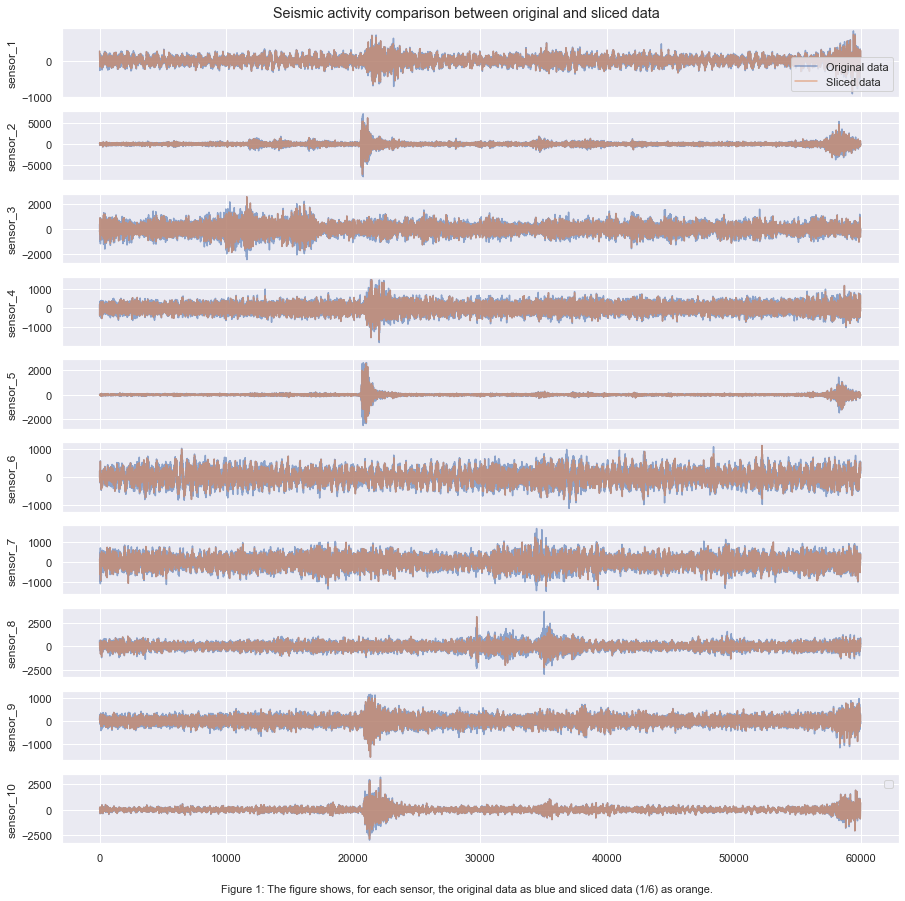

In [19]:
fig, axes = plt.subplots(len(segment.columns),figsize=(15,15), sharex=True)

short_segment = segment.iloc[::6]

for i, column in enumerate(segment.columns):
    if i==0: label, short_label = "Original data", "Sliced data"
    else: label, short_label = None, None
    
    sns.lineplot(data=segment[column], ax=axes[i], label=label, alpha=0.6)
    sns.lineplot(data=short_segment[column], ax=axes[i], label=short_label, alpha=0.6)

plt.suptitle('Seismic activity comparison between original and sliced data', x=0.5, y=0.90)
plt.figtext(0.5,0.08,'Figure {}: The figure shows, for each sensor, the original data as blue and sliced data (1/6) as orange.'.format(fig_nr), fontsize=11, horizontalalignment="center")
plt.legend()
#plt.savefig("seismoplot", bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig_nr = fig_nr + 1

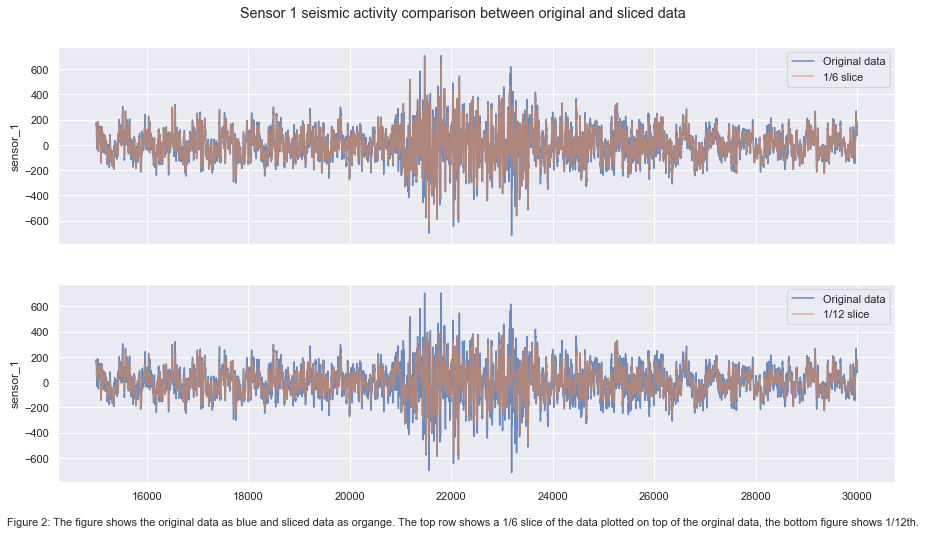

In [20]:
shorter_segment = segment.iloc[::12]
    
fig, axes = plt.subplots(nrows=2,figsize=(15,8), sharex=True)

sns.lineplot(data=segment['sensor_1'].loc[15000:30000], ax=axes[0], label="Original data", alpha=0.8)
sns.lineplot(data=short_segment['sensor_1'].loc[15000:30000], ax=axes[0], label="1/6 slice", alpha=0.6)

sns.lineplot(data=segment['sensor_1'].loc[15000:30000], ax=axes[1], label="Original data", alpha=0.8)
sns.lineplot(data=shorter_segment['sensor_1'].loc[15000:30000], ax=axes[1], label="1/12 slice", alpha=0.6)

#plt.savefig("seismoplot", bbox_inches = 'tight', pad_inches = 0)
plt.suptitle('Sensor 1 seismic activity comparison between original and sliced data', x=0.5, y=0.95)
plt.figtext(0.5,0.05,'Figure {}: The figure shows the original data as blue and sliced data as organge. The top row shows a 1/6 slice of the data plotted on top of the orginal data, the bottom figure shows 1/12th.'
            .format(fig_nr), fontsize=11, horizontalalignment="center")
plt.show()

fig_nr = fig_nr + 1

We wanted to explore the possiblities of implementing Continuous Wavelet Transformation into our data. To see what that looks like we tried to implement a simple figure of CWT on the segment which we already had.

10010


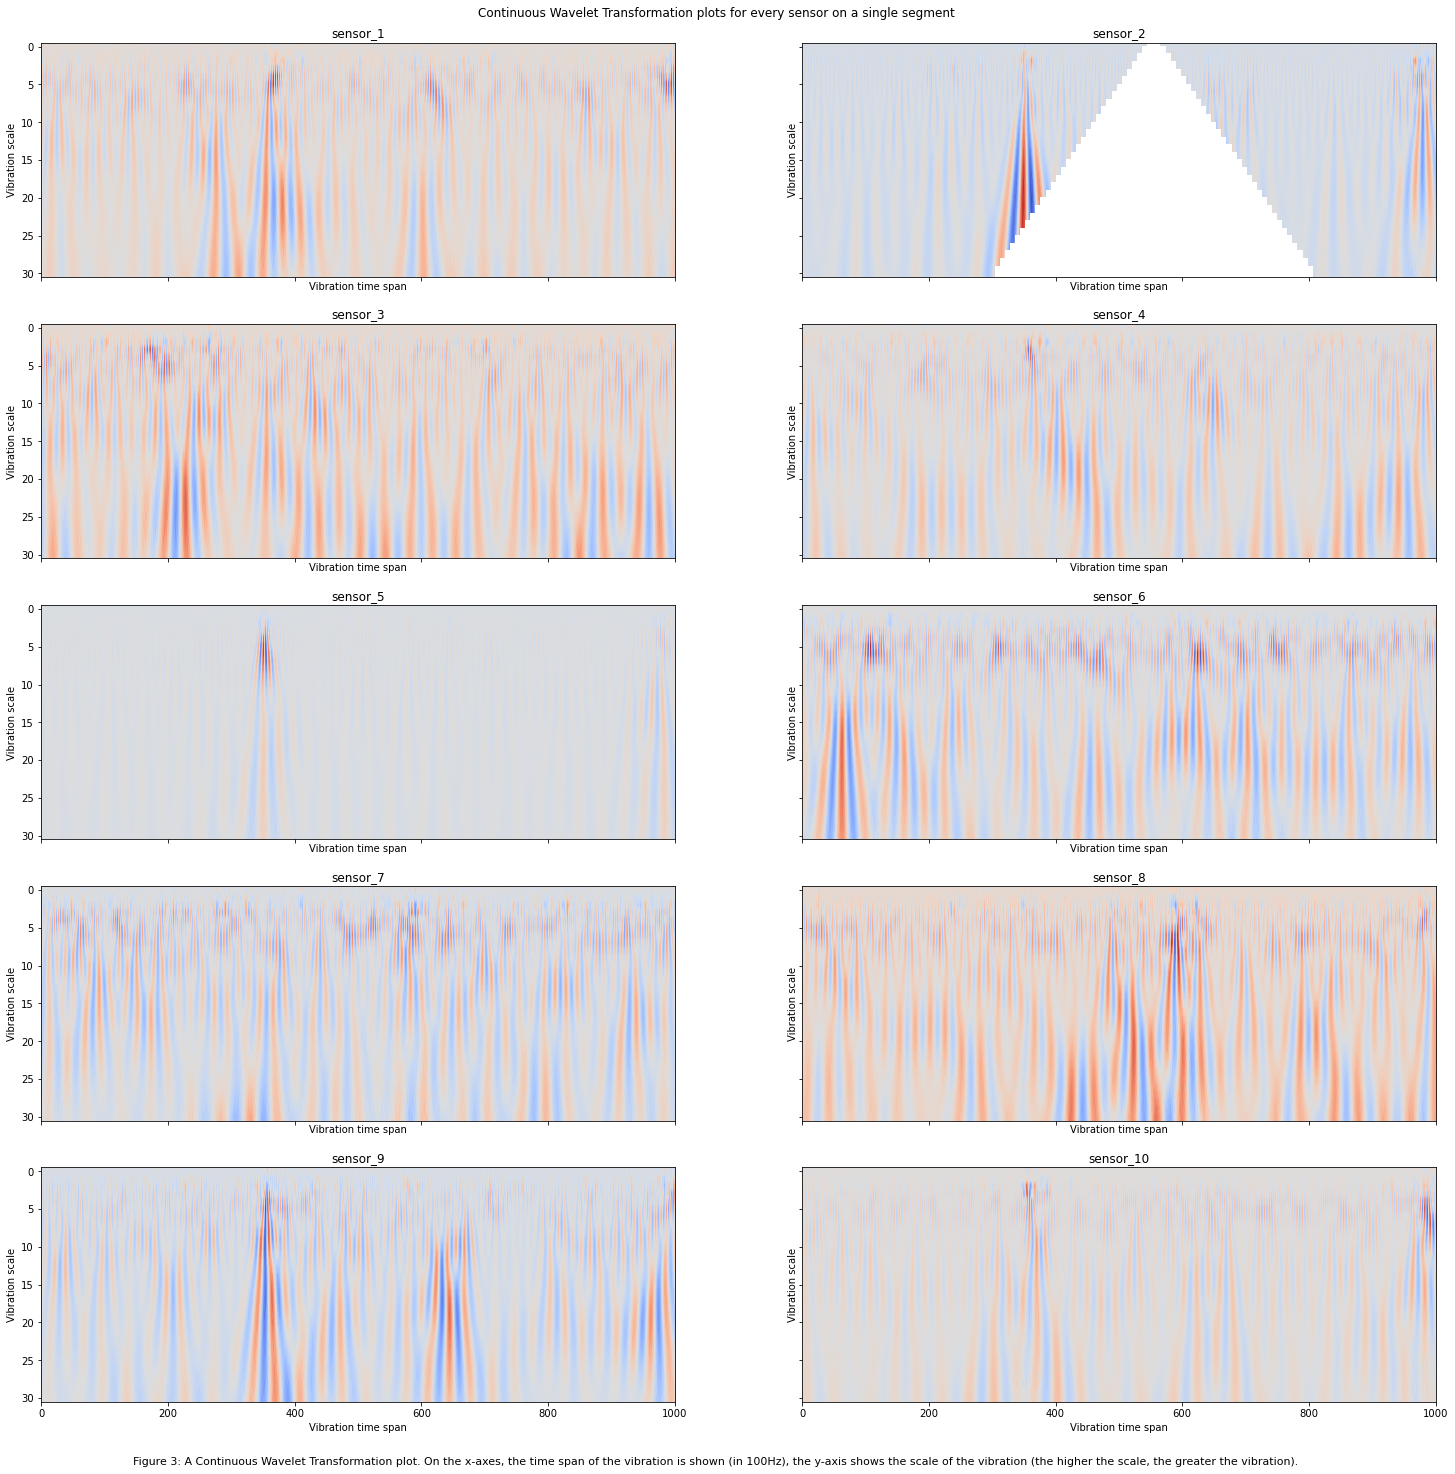

In [21]:
# CWT does not work well with seaborn so we should temporarily disable it
sns.reset_orig()

# We grab 1/60th of the data, else the CWT figure would be unreadable
short_segment= segment.iloc[::60].reset_index(drop=True)
sensor_1 = segment["sensor_1"].values
scales = np.arange(1, 32)

fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(25,25))

for ax, column in zip(axs.flat, segment):
    coeffs, freqs = pywt.cwt(short_segment[column].values , scales, 'morl')
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    ax.set_title(column)
    ax.set_xlabel("Vibration time span")
    ax.set_ylabel("Vibration scale")

print(short_segment.size)

fig.suptitle('Continuous Wavelet Transformation plots for every sensor on a single segment', x=0.5, y=0.9)
plt.figtext(0.5,0.09,'Figure {}: A Continuous Wavelet Transformation plot. On the x-axes, the time span of the vibration is shown (in 100Hz), the y-axis shows the scale of the vibration (the higher the scale, the greater the vibration).'.format(fig_nr), fontsize=11, horizontalalignment="center")

plt.show()

fig_nr = fig_nr + 1

coeffs.shape

sns.set_theme()

Continuous wavelet transformation provides a simple way to visualize our data into a 1-D plot. Furthermore, the coefficients from these plots could potentially be used as features for our data set as a means of dimensionality reduction. However, we can see that similarity between sensors is vague and sometimes non-existent. We also have to consider that, for above plots, we are only using 1/60th of the data, meaning that these plots do not yet represent the overall structure of our data. This begs the question if implementing CWT as a feature would yield any benefits. We keep this option open for further exploration.

### File extraction

In [60]:
# You will see values like these quite often. We use them to decide whether we want to generate an intermediate data set or not. 
# because this generation takes quite a long time, these values are set to False by default
generate_train_set = False
generate_test_set = False

In [22]:
# Using our own function, we generate an aggregated data set from our seperate train and test segments
if(generate_train_set): generate_aggregation("*", "data/train", "data/intermediate/aggregated_train")
    
if(generate_test_set): generate_aggregation("*", "data/test", "data/intermediate/aggregated_test")

### Using aggregated data

In [23]:
df = pd.read_csv("data/intermediate/aggregated_train.csv")

df.head()

sensor_1_kurtosis  sensor_10_kurtosis  sensor_2_kurtosis  \
0           2.873691           14.978789          35.123455   
1           0.154876            0.160791           0.735062   
2           0.034508            0.193508           0.714999   
3           3.927669            2.732420           9.141479   
4           0.824943            1.135692           1.735042   

   sensor_3_kurtosis  sensor_4_kurtosis  sensor_5_kurtosis  sensor_6_kurtosis  \
0           1.653106           1.425662         110.539572           0.186371   
1           0.253124           0.358472           0.686427          -0.644394   
2           0.194834           0.041640           0.408451          -0.404377   
3          -0.170069           0.888390           2.231623          -0.111471   
4           1.045936           0.999060           1.639048           2.657079   

   sensor_7_kurtosis  sensor_8_kurtosis  sensor_9_kurtosis  ...  \
0           0.503200           2.805086           2.838816  ...   
1           5.497645           1.137073           0.259711  ...   
2           0.889926           0.154205           0.128774  ...   
3           0.243225           0.552680           0.985682  ...   
4           3.257830           5.435835           1.823561  ...   

   sensor_10_sum  sensor_2_sum  sensor_3_sum  sensor_4_sum  sensor_5_sum  \
0        53806.0      135647.0      131535.0       -8882.0      -15788.0   
1      -445008.0      423845.0     -116686.0      292584.0        -448.0   
2       -89519.0      -98787.0      -79718.0     -624755.0     -221847.0   
3       -82408.0       71688.0     -261950.0      213416.0       14936.0   
4      1922895.0     -272664.0      -73967.0       31312.0       44982.0   

   sensor_6_sum  sensor_7_sum  sensor_8_sum  sensor_9_sum  segment_id  
0       97807.0      -36912.0      -10678.0      -24167.0  1000015382  
1     -138394.0      247567.0       61903.0      146230.0  1000554676  
2     -223684.0      169076.0      510842.0      226729.0  1000745424  
3     -698973.0     -186359.0      -16925.0      104900.0  1001461087  
4       49284.0     -373084.0      221986.0       50583.0  1001732002  

[5 rows x 121 columns]

In [24]:
print("uniques in percentile_50: ", pd.unique(df[list(df.filter(regex='percentile_50'))].values.ravel()))

uniques in percentile_50:  [ 0. nan]


In [25]:
# remove 'sum' values that are 0
cols = list(df.filter(regex='sum'))
df_filtered = df
df_filtered[cols] = df[cols].replace({0:np.nan})

#  remove median & 50th percentile (these are both empty)
df_filtered = df_filtered[df_filtered.columns.drop(list(df_filtered.filter(regex='percentile_50')))]

df.head()

sensor_1_kurtosis  sensor_10_kurtosis  sensor_2_kurtosis  \
0           2.873691           14.978789          35.123455   
1           0.154876            0.160791           0.735062   
2           0.034508            0.193508           0.714999   
3           3.927669            2.732420           9.141479   
4           0.824943            1.135692           1.735042   

   sensor_3_kurtosis  sensor_4_kurtosis  sensor_5_kurtosis  sensor_6_kurtosis  \
0           1.653106           1.425662         110.539572           0.186371   
1           0.253124           0.358472           0.686427          -0.644394   
2           0.194834           0.041640           0.408451          -0.404377   
3          -0.170069           0.888390           2.231623          -0.111471   
4           1.045936           0.999060           1.639048           2.657079   

   sensor_7_kurtosis  sensor_8_kurtosis  sensor_9_kurtosis  ...  \
0           0.503200           2.805086           2.838816  ...   
1           5.497645           1.137073           0.259711  ...   
2           0.889926           0.154205           0.128774  ...   
3           0.243225           0.552680           0.985682  ...   
4           3.257830           5.435835           1.823561  ...   

   sensor_10_sum  sensor_2_sum  sensor_3_sum  sensor_4_sum  sensor_5_sum  \
0        53806.0      135647.0      131535.0       -8882.0      -15788.0   
1      -445008.0      423845.0     -116686.0      292584.0        -448.0   
2       -89519.0      -98787.0      -79718.0     -624755.0     -221847.0   
3       -82408.0       71688.0     -261950.0      213416.0       14936.0   
4      1922895.0     -272664.0      -73967.0       31312.0       44982.0   

   sensor_6_sum  sensor_7_sum  sensor_8_sum  sensor_9_sum  segment_id  
0       97807.0      -36912.0      -10678.0      -24167.0  1000015382  
1     -138394.0      247567.0       61903.0      146230.0  1000554676  
2     -223684.0      169076.0      510842.0      226729.0  1000745424  
3     -698973.0     -186359.0      -16925.0      104900.0  1001461087  
4       49284.0     -373084.0      221986.0       50583.0  1001732002  

[5 rows x 121 columns]

In [26]:
# Check which columns have empty values
df.columns[df.isnull().any()]

Index(['sensor_1_kurtosis', 'sensor_10_kurtosis', 'sensor_2_kurtosis',
       'sensor_3_kurtosis', 'sensor_5_kurtosis', 'sensor_7_kurtosis',
       'sensor_8_kurtosis', 'sensor_9_kurtosis', 'sensor_1_max',
       'sensor_10_max', 'sensor_2_max', 'sensor_3_max', 'sensor_5_max',
       'sensor_7_max', 'sensor_8_max', 'sensor_9_max', 'sensor_1_mean',
       'sensor_10_mean', 'sensor_2_mean', 'sensor_3_mean', 'sensor_5_mean',
       'sensor_7_mean', 'sensor_8_mean', 'sensor_9_mean', 'sensor_1_min',
       'sensor_10_min', 'sensor_2_min', 'sensor_3_min', 'sensor_5_min',
       'sensor_7_min', 'sensor_8_min', 'sensor_9_min',
       'sensor_1_percentile_10', 'sensor_10_percentile_10',
       'sensor_2_percentile_10', 'sensor_3_percentile_10',
       'sensor_5_percentile_10', 'sensor_7_percentile_10',
       'sensor_8_percentile_10', 'sensor_9_percentile_10',
       'sensor_1_percentile_25', 'sensor_10_percentile_25',
       'sensor_2_percentile_25', 'sensor_3_percentile_25',
       'sensor_5_

It looks like quite a lot of sensors have some missing values. Let's check to what extend this is the case.

In [27]:
missing_sensors = dict()

# Check how many missing values each sensor has
for column, missing_values in zip(df.columns, df.isnull().sum(axis = 0)):
    if 'sensor' in column:
        split = column.split('_')
        col = split[0]+"_"+split[1]
        missing_sensors[col] = missing_values
    
print(missing_sensors)

{'sensor_1': 24, 'sensor_10': 24, 'sensor_2': 835, 'sensor_3': 435, 'sensor_4': 0, 'sensor_5': 595, 'sensor_6': 0, 'sensor_7': 42, 'sensor_8': 440, 'sensor_9': 124}


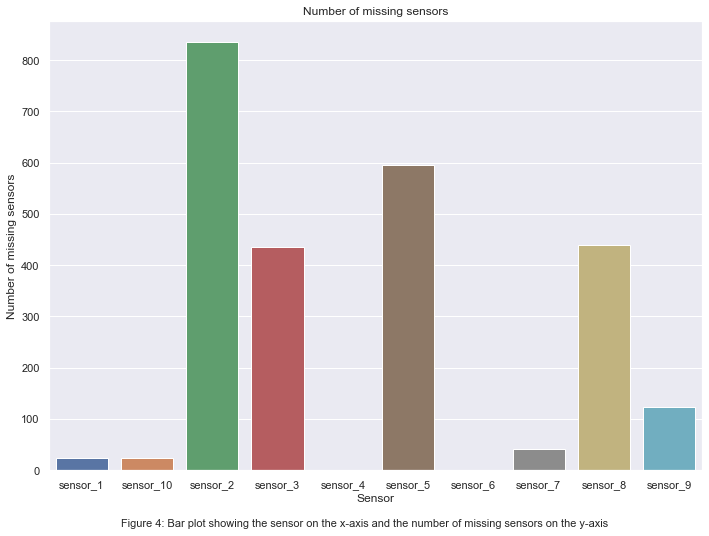

In [28]:
keys = list(missing_sensors.keys())
vals = [float(missing_sensors[k]) for k in keys]

a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x=keys, y=vals, ax=ax)
plt.title("Number of missing sensors")
plt.xlabel("Sensor")
plt.ylabel("Number of missing sensors")
plt.figtext(0.5,0.03,'Figure {}: Bar plot showing the sensor on the x-axis and the number of missing sensors on the y-axis'.format(fig_nr), fontsize=11, horizontalalignment="center")

fig_nr = fig_nr + 1

In [29]:
# Clean the dataset using our previously defined function
df = clean_df(df)

df.head()

sensor_1_kurtosis  sensor_10_kurtosis  sensor_2_kurtosis  \
segment_id                                                             
1443158011          -0.500867           -0.756292           1.082533   
179584121            0.612155            0.578505           2.294547   
1848578834           0.099924           -0.514466           0.542925   
1925307864          -0.374988           -0.176205          -0.205315   
517946260           -0.147100            0.214609           0.041163   

            sensor_3_kurtosis  sensor_4_kurtosis  sensor_5_kurtosis  \
segment_id                                                            
1443158011          -0.369448           0.537462           0.947902   
179584121            0.363843           1.083448           0.551613   
1848578834           0.183253           0.265696           0.350836   
1925307864          -0.400745          -0.429961          -0.214006   
517946260            0.025550           0.000122           4.265570   

            sensor_6_kurtosis  sensor_7_kurtosis  sensor_8_kurtosis  \
segment_id                                                            
1443158011          -1.082187          20.971128          65.894733   
179584121            0.100413           0.990655           1.874555   
1848578834          -0.984722           9.797522          11.821548   
1925307864          -0.466535          -0.346940          -0.409043   
517946260            0.236130           0.046331           0.029653   

            sensor_9_kurtosis  ...  sensor_10_sum  sensor_2_sum  sensor_3_sum  \
segment_id                     ...                                              
1443158011           0.360613  ...      5443237.0    -9687742.0   -24616079.0   
179584121            0.807765  ...    -27591593.0    -6987940.0   -34675489.0   
1848578834           0.381292  ...    -30138921.0   -14713477.0     4417294.0   
1925307864          -0.481846  ...    -26132104.0    -8832804.0   -15820048.0   
517946260           -0.233974  ...     -4940102.0     3772988.0     4769316.0   

            sensor_4_sum  sensor_5_sum  sensor_6_sum  sensor_7_sum  \
segment_id                                                           
1443158011     6573301.0    -4718989.0   -21918247.0       87729.0   
179584121    -19051459.0    -3466954.0   -40274251.0   -47237664.0   
1848578834   -13398598.0    -1619204.0   -25743099.0      114191.0   
1925307864   -27296327.0    -3840282.0   -25100803.0   -39263658.0   
517946260     -1375227.0     1233322.0    -1100525.0       73041.0   

            sensor_8_sum  sensor_9_sum  time_to_eruption  
segment_id                                                
1443158011      -73423.0    14772926.0          13731766  
179584121    -33323029.0   -25148116.0          19387989  
1848578834      -14172.0   -14328657.0          13982533  
1925307864   -58156438.0   -15136061.0           5538535  
517946260       399783.0     3393940.0           3975965  

[5 rows x 121 columns]

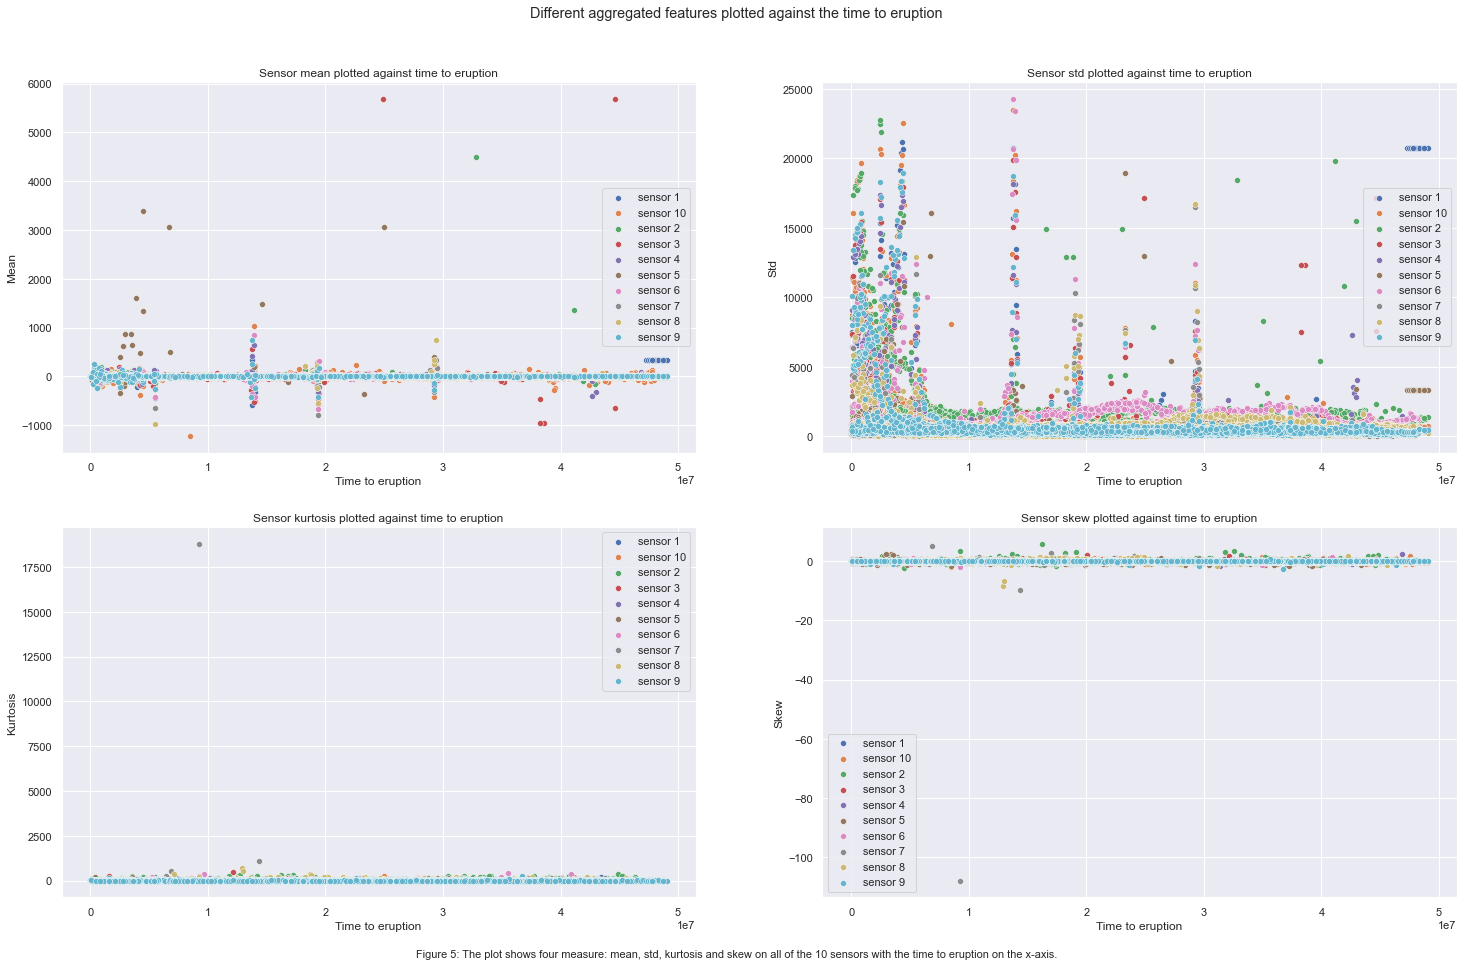

In [30]:
fig, axes = plt.subplots(2,2,figsize=(25,15))

metrics = ['mean', 'std', 'kurtosis', 'skew']

for i, ax in enumerate(axes.flatten()):
    for sensor_metric in list(df.filter(regex=metrics[i])):
        
        # Some lines for presenting the labels
        split = sensor_metric.split('_')
        sensor = split[0]+" "+split[1]
        
        sns.scatterplot(x="time_to_eruption", y=sensor_metric, data=df, ax=ax, label=sensor)
        
    ax.set_title("Sensor "+metrics[i]+" plotted against time to eruption")
    ax.set_ylabel(metrics[i].capitalize())
    ax.set_xlabel('Time to eruption')

plt.suptitle("Different aggregated features plotted against the time to eruption", x=0.5, y=0.95)
plt.figtext(0.5,0.07,'Figure {}: The plot shows four measure: mean, std, kurtosis and skew on all of the 10 sensors with the time to eruption on the x-axis.'.format(fig_nr), fontsize=11, horizontalalignment="center")
plt.show()

fig_nr = fig_nr + 1

What is interesting to see, is that all of our values hover around the y-axis value 0. This can be explained by our use of seismic data, which means that any positive vibration eventually comes back as a negative vibration (just image the lines that a seismograph makes). Because we generated our train and test sets on these vibrations it is no surprise that our values hover around 0. If we really want to find any linear combinations, it should be essential for us to take the absolute values of our original dataset.

#### Model training

In [31]:
# X so that we remove time_to_eruption and sensor_id
X = df.drop(['time_to_eruption'], axis=1).values

# y so that we only have the time_to_eruption
y = df['time_to_eruption'].values

print(y)

[13731766 19387989 13982533 ... 47775708 47878878 47795821]


#### Linear regression

In [33]:
# Train a simple linear regression model and plot the results
r2_sc, mae_score = linear_regression_generator(X, y)
    
print("Best R2 score: {}".format(r2_sc.mean()))
print("Best MAE: {}".format(mae_score.mean()))

Best R2 score: -9.13294698885597
Best MAE: 11582628.917439725


#### Random Forest

Tree depth: 100


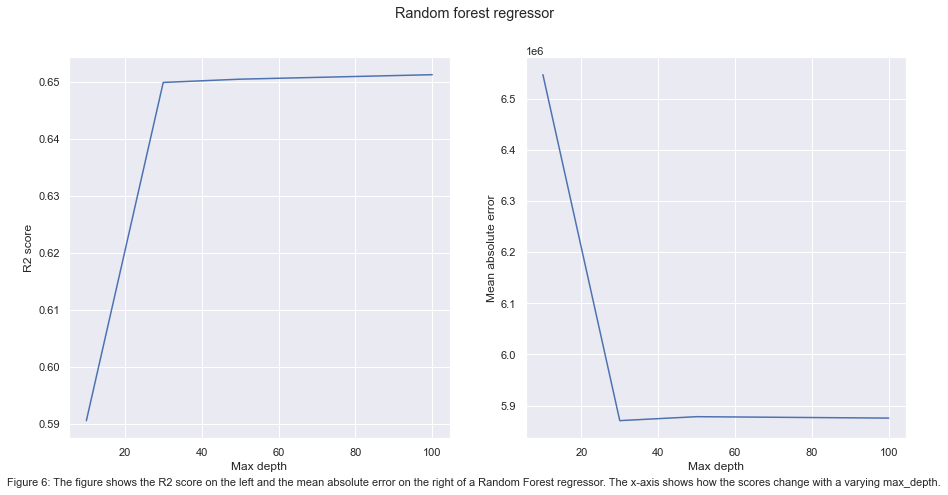

Best R2 score: 0.6512128434459626 with 100 max_depth 
Best MAE: 5870554.731595284 with 30 max_depth 


In [34]:
best_r2, best_mae = random_forest_generator(
    [None, 10, 30, 50, 100],
    X, 
    y, 
    'Figure {}: The figure shows the R2 score on the left and the mean absolute error on the right of a Random Forest regressor. The x-axis shows how the scores change with a varying max_depth.'.format(fig_nr), 
    "Random forest regressor")
fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

##### K-Nearest Neighbor regressor

Neighbors trained: 40


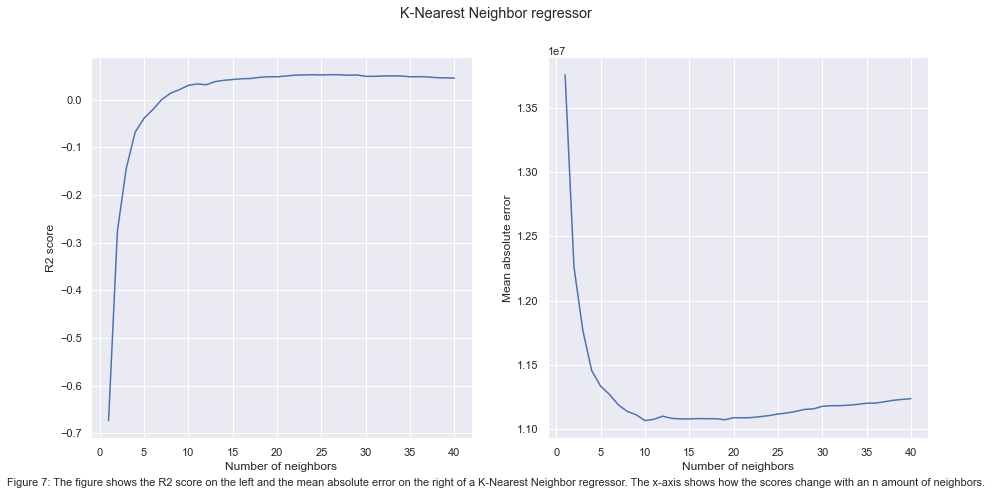

Best R2 score: 0.05230842004056787 with 26 max_depth 
Best MAE: 11066372.727955129 with 10 max_depth 


In [35]:
best_r2, best_mae = knn_generator(
    range(1,41),
    X, 
    y, 
    'Figure {}: The figure shows the R2 score on the left and the mean absolute error on the right of a K-Nearest Neighbor regressor. The x-axis shows how the scores change with an n amount of neighbors.'.format(fig_nr), 
    "K-Nearest Neighbor regressor")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

On the regular data, Random Forest proves to be a better performing regressor. The model managed to achieve an R2 score of 0.651 and a MAE of just around $5.8*10^6$, which is definitely not the worst performance for a first try. Using the sample rate of the Kaggle competition page we can estimate that the error is around 18 hours, which is more than enough time to evacuate citizens to safety

K-Nearest Neighbor on the other hand performs poorly. The model shows mostly a negative R2 score and more than doubles the mean absolute error.

However, we have seen that the use of absolute data can still make a difference. Our assumption is that, because of the many '0' values currently in the data, KNN finds it hard to correctly interpret which data point belongs to which 'neighbor'. To try and solve this problem, we continue by creating and using absolute data in the next step.

### Trying absolute data

In [36]:
generate_abs_train_set = False
generate_abs_test_set = False

In [37]:
if(generate_abs_train_set): generate_aggregation("*", "data/train", "data/intermediate/aggregated_abs_train", absolute=True, slice_amount=6)
    
if(generate_abs_test_set): generate_aggregation("*", "data/test", "data/intermediate/aggregated_abs_test", absolute=True, slice_amount=6)

In [38]:
# Read file containing absolute data 
df_abs = pd.read_csv("data/intermediate/aggregated_abs_train.csv")

In [39]:
# Clean the data and show the first 5 results
df_abs = clean_df(df_abs)

df_abs.head()

sensor_1_kurtosis  sensor_10_kurtosis  sensor_2_kurtosis  \
segment_id                                                             
757144677            3.526094            8.940736          25.919718   
684012682            9.732040           11.343385          16.772796   
150692731            3.123129            7.152505          19.425024   
658099461            5.093539           18.528364          33.755994   
1726437005           4.333028            6.338226          14.724671   

            sensor_3_kurtosis  sensor_4_kurtosis  sensor_5_kurtosis  \
segment_id                                                            
757144677            2.520061           1.397474          49.799338   
684012682            3.739625           5.267583          58.701665   
150692731            4.543157           4.667316          42.722814   
658099461            3.506672           8.530541          30.182713   
1726437005           4.428419           5.891275          25.811665   

            sensor_6_kurtosis  sensor_7_kurtosis  sensor_8_kurtosis  \
segment_id                                                            
757144677           10.652386           3.148650           1.813752   
684012682            2.468255           1.030223           3.270216   
150692731            1.294553           1.663043           1.004756   
658099461           14.197751          20.784153          22.545142   
1726437005           2.135182           2.435776           0.476493   

            sensor_9_kurtosis  ...  sensor_10_sum  sensor_2_sum  sensor_3_sum  \
segment_id                     ...                                              
757144677            2.630062  ...      1405267.0     3345468.0      774729.0   
684012682            4.748106  ...      1488792.0     2111899.0      702688.0   
150692731            8.054718  ...      1372630.0     1994281.0      646025.0   
658099461            9.875920  ...      1557164.0     2947197.0      687986.0   
1726437005           4.817078  ...      1391401.0     2058951.0      687401.0   

            sensor_4_sum  sensor_5_sum  sensor_6_sum  sensor_7_sum  \
segment_id                                                           
757144677      1747194.0      637002.0     3871824.0     3138344.0   
684012682       805219.0      451180.0     1713362.0     1020445.0   
150692731       787942.0      406657.0     1711440.0     1041929.0   
658099461       860351.0     1178577.0     3512114.0     1202095.0   
1726437005      757626.0      420941.0     2069531.0     1056078.0   

            sensor_8_sum  sensor_9_sum  time_to_eruption  
segment_id                                                
757144677      2364276.0     1179857.0          33318990  
684012682      1292443.0      820112.0          19770960  
150692731      1146433.0      792735.0          21438625  
658099461      1991485.0      881290.0          31870009  
1726437005     1192538.0      774688.0          21379271  

[5 rows x 121 columns]

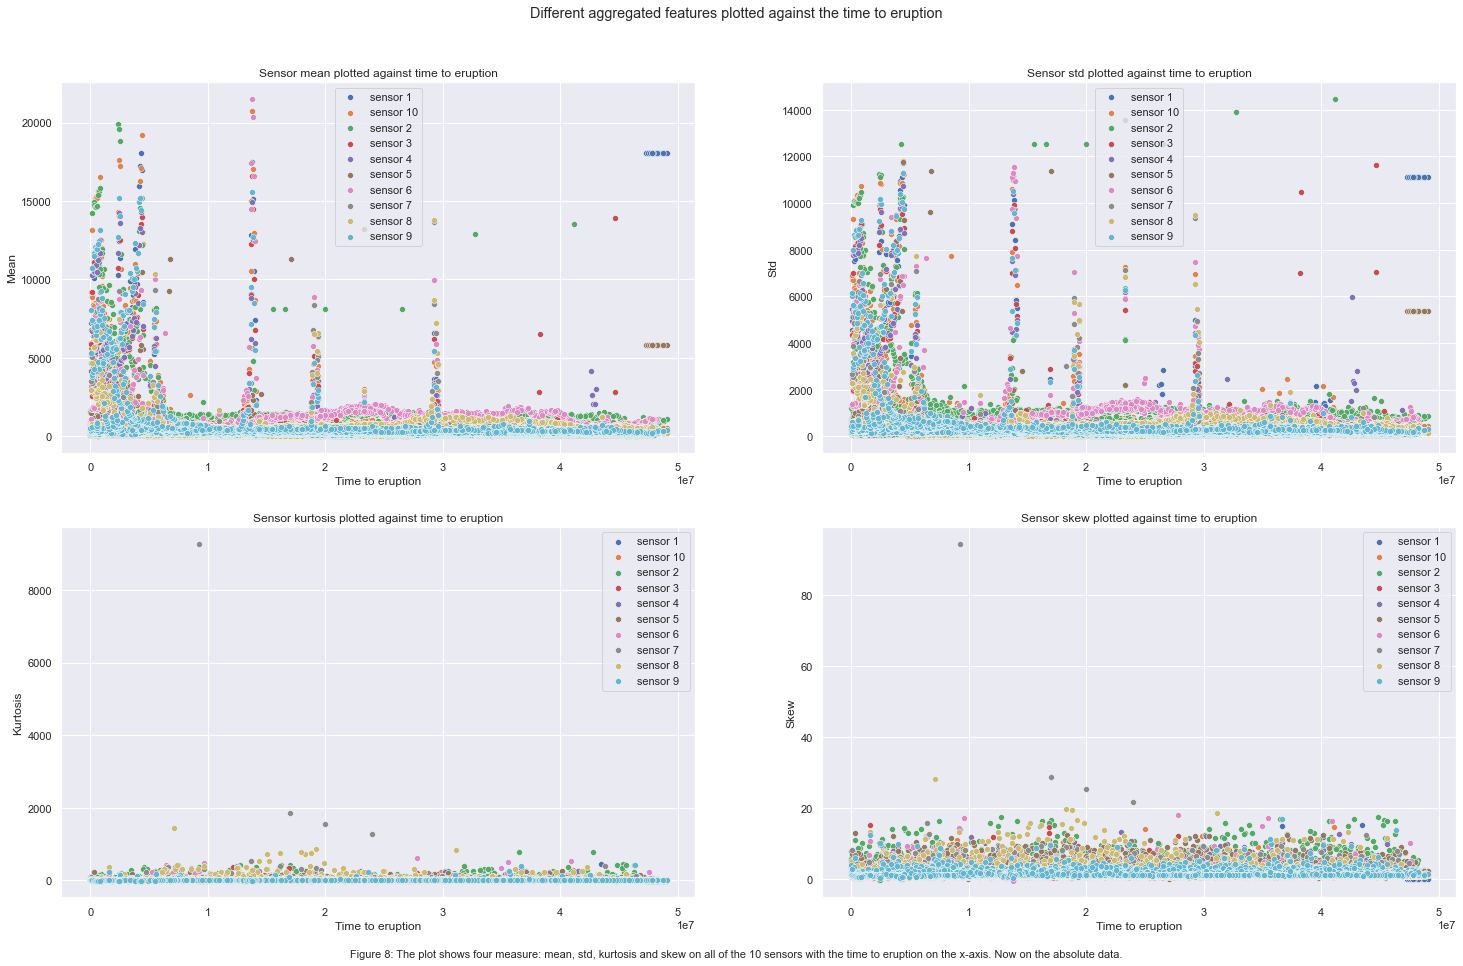

In [40]:
fig, axes = plt.subplots(2,2,figsize=(25,15))

metrics = ['mean', 'std', 'kurtosis', 'skew']

for i, ax in enumerate(axes.flatten()):
    for sensor_metric in list(df_abs.filter(regex=metrics[i])):
        
        # Some lines for presenting the labels
        split = sensor_metric.split('_')
        sensor = split[0]+" "+split[1]
        
        sns.scatterplot(x="time_to_eruption", y=sensor_metric, data=df_abs, ax=ax, label=sensor)
        
    ax.set_title("Sensor "+metrics[i]+" plotted against time to eruption")
    ax.set_ylabel(metrics[i].capitalize())
    ax.set_xlabel('Time to eruption')

plt.suptitle("Different aggregated features plotted against the time to eruption", x=0.5, y=0.95)
plt.figtext(0.5,0.07,'Figure {}: The plot shows four measure: mean, std, kurtosis and skew on all of the 10 sensors with the time to eruption on the x-axis. Now on the absolute data.'.format(fig_nr), fontsize=11, horizontalalignment="center")
plt.show()

fig_nr = fig_nr + 1

As seen from the figure above, more and more aggregated points are not hovering around the value '0' any more. This should make it easier for models like KNN and to more accurately predict the time to eruption.

Note however that, even with the absolute data, there are still no 'real' linear relationships between features and their data points. Because of this we predict that linear regression will still perform poorly on the absolute data set (which we secretly hoped would be resolved). Because of these findings, the next best approach is to keep exploring non-linear models. 

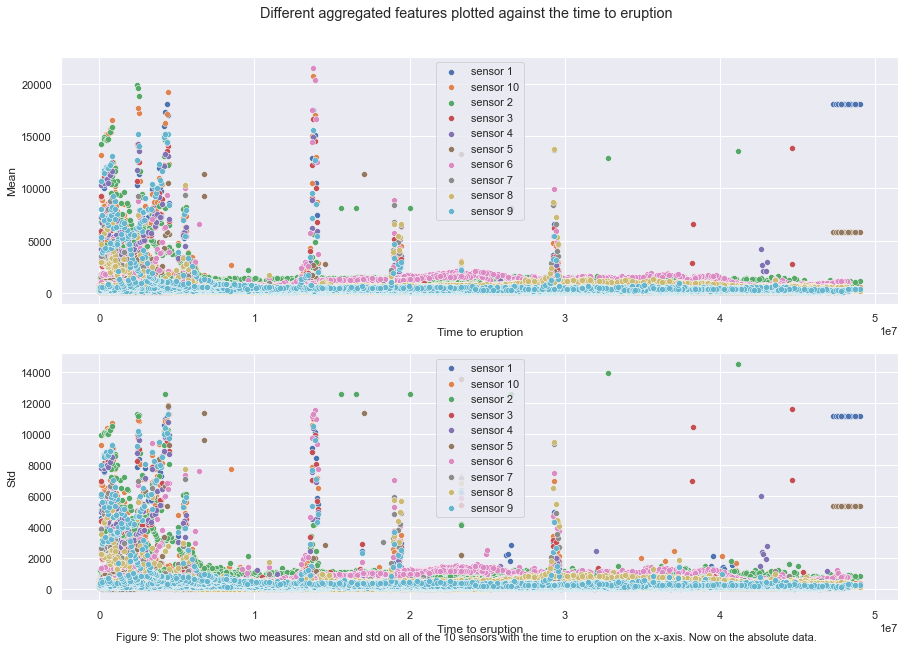

In [41]:
fig, axes = plt.subplots(2,1,figsize=(15,10))

metrics = ['mean', 'std']

for i, ax in enumerate(axes.flatten()):
    for sensor_metric in list(df_abs.filter(regex=metrics[i])):
        
        # Some lines for presenting the labels
        split = sensor_metric.split('_')
        sensor = split[0]+" "+split[1]
        
        sns.scatterplot(x="time_to_eruption", y=sensor_metric, data=df_abs, ax=ax, label=sensor)
        
    ax.set_ylabel(metrics[i].capitalize())
    ax.set_xlabel('Time to eruption')

# plt.savefig("linear", bbox_inches = 'tight', pad_inches = 0)

plt.suptitle("Different aggregated features plotted against the time to eruption", x=0.5, y=0.95)
plt.figtext(0.5,0.07,'Figure {}: The plot shows two measures: mean and std on all of the 10 sensors with the time to eruption on the x-axis. Now on the absolute data.'.format(fig_nr), fontsize=11, horizontalalignment="center")
plt.show()

fig_nr = fig_nr + 1

In [42]:
# X so that we remove time_to_eruption and sensor_id
X_abs = df_abs.drop(['time_to_eruption'], axis=1).values

# y so that we only have the time_to_eruption
y_abs = df_abs['time_to_eruption'].values

X_abs.shape

(4431, 120)

In [43]:
r2_sc, mae_score = linear_regression_generator(X_abs, y_abs)
    
print("Best R2 score: {}".format(r2_sc.mean()))
print("Best MAE: {}".format(mae_score.mean()))

Best R2 score: -8.467333778031279
Best MAE: 11777429.680049187


As predicted, Linear Regression still performs poorly, even after our absolute aggregation step. This model will thus not be further explored

Tree depth: 100


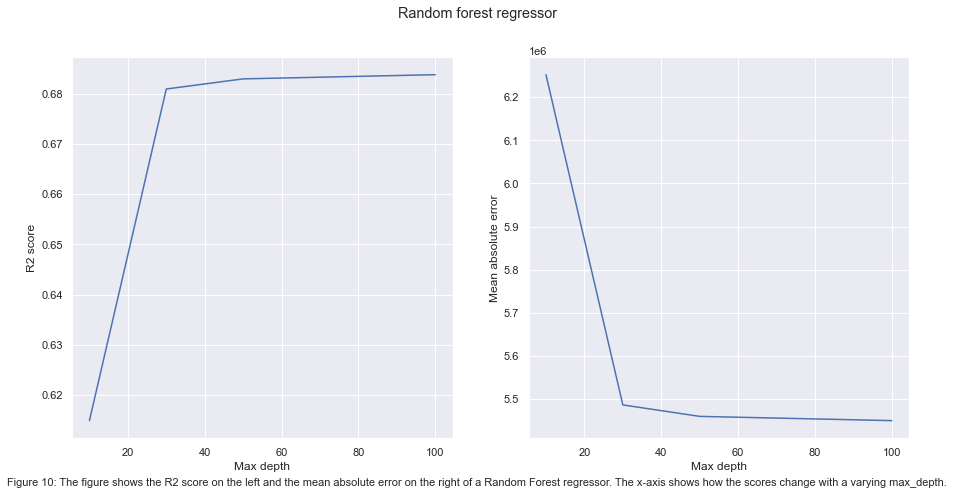

Best R2 score: 0.6838285836947016 with 100 max_depth 
Best MAE: 5449830.386670302 with 100 max_depth 


In [44]:
best_r2, best_mae = random_forest_generator(
    [None, 10, 30, 50, 100], 
    X_abs, 
    y_abs, 
    'Figure {}: The figure shows the R2 score on the left and the mean absolute error on the right of a Random Forest regressor. The x-axis shows how the scores change with a varying max_depth.'.format(fig_nr), 
    "Random forest regressor")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

Neighbors trained: 40


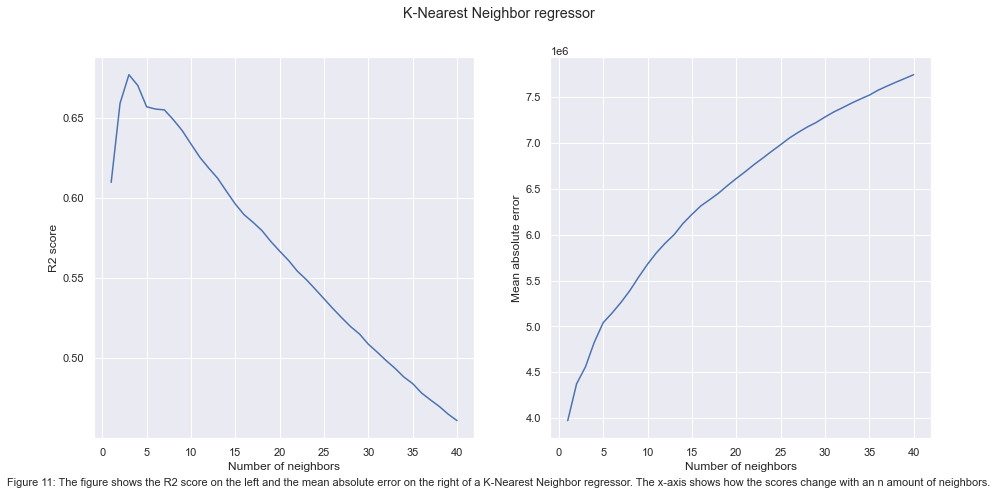

Best R2 score: 0.6768638972680027 with 3 max_depth 
Best MAE: 3973215.4259202196 with 1 max_depth 


In [45]:
best_r2, best_mae = knn_generator(
    range(1,41),
    X_abs, 
    y_abs, 
    'Figure {}: The figure shows the R2 score on the left and the mean absolute error on the right of a K-Nearest Neighbor regressor. The x-axis shows how the scores change with an n amount of neighbors.'.format(fig_nr), 
    "K-Nearest Neighbor regressor")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

### Including Principal Component Analysis

Principal Component Analysis is a dimensionality reduction technique, and is highly effective for representing high-dimensional data in smaller dimensions called 'principal components', which explain the variance in the data. We could choose to only apply PCA to the data and see how the accuracy of the model changes. But, because we already have an aggregated data set, we have decided to first see how PCA performs in addition to this already existing data set.

After some own experimenting, we found that not a lot of variance in the data is represented in the first principal component, around 43% to be precise. The first four principle components, however, seem to represent around 70% of the data. Any more PCs does not drastically increase this number.

In [46]:
generate_abs_pca_train_set = False
generate_abs_pca_test_set = False

In [47]:
if(generate_abs_pca_train_set): generate_aggregation("*", "data/train", "data/intermediate/aggregated_abs_pca_train", absolute=True, slice_amount=6, principal_components=4)
    
if(generate_abs_pca_test_set): generate_aggregation("*", "data/test", "data/intermediate/aggregated_abs_pca_test", absolute=True, slice_amount=6, principal_components=4)

In [48]:
df_pca = pd.read_csv("data/intermediate/aggregated_abs_pca_train.csv")

df_pca = clean_df(df_pca)

df_pca.head()

pc1_kurtosis  pc2_kurtosis  pc3_kurtosis  pc4_kurtosis  \
segment_id                                                           
757144677       9.036387      5.676238      1.200403      1.461557   
684012682       6.660360      3.669002      1.311476      0.691574   
150692731       4.817638      4.229741      0.556770      0.343009   
658099461       9.843701     13.697599      8.392832      8.294375   
1726437005      3.238031      3.811596      0.599376      0.449980   

            sensor_1_kurtosis  sensor_10_kurtosis  sensor_2_kurtosis  \
segment_id                                                             
757144677            3.526094            8.940736          25.919718   
684012682            9.732040           11.343385          16.772796   
150692731            3.123129            7.152505          19.425024   
658099461            5.093539           18.528364          33.755994   
1726437005           4.333028            6.338226          14.724671   

            sensor_3_kurtosis  sensor_4_kurtosis  sensor_5_kurtosis  ...  \
segment_id                                                           ...   
757144677            2.520061           1.397474          49.799338  ...   
684012682            3.739625           5.267583          58.701665  ...   
150692731            4.543157           4.667316          42.722814  ...   
658099461            3.506672           8.530541          30.182713  ...   
1726437005           4.428419           5.891275          25.811665  ...   

            sensor_10_sum  sensor_2_sum  sensor_3_sum  sensor_4_sum  \
segment_id                                                            
757144677       1405267.0     3345468.0      774729.0     1747194.0   
684012682       1488792.0     2111899.0      702688.0      805219.0   
150692731       1372630.0     1994281.0      646025.0      787942.0   
658099461       1557164.0     2947197.0      687986.0      860351.0   
1726437005      1391401.0     2058951.0      687401.0      757626.0   

            sensor_5_sum  sensor_6_sum  sensor_7_sum  sensor_8_sum  \
segment_id                                                           
757144677       637002.0     3871824.0     3138344.0     2364276.0   
684012682       451180.0     1713362.0     1020445.0     1292443.0   
150692731       406657.0     1711440.0     1041929.0     1146433.0   
658099461      1178577.0     3512114.0     1202095.0     1991485.0   
1726437005      420941.0     2069531.0     1056078.0     1192538.0   

            sensor_9_sum  time_to_eruption  
segment_id                                  
757144677      1179857.0          33318990  
684012682       820112.0          19770960  
150692731       792735.0          21438625  
658099461       881290.0          31870009  
1726437005      774688.0          21379271  

[5 rows x 165 columns]

In [49]:
X_pca = df_pca.drop(['time_to_eruption'], axis=1).values

y_pca = df_pca['time_to_eruption'].values

X_pca.shape

(4431, 164)

Tree depth: 100


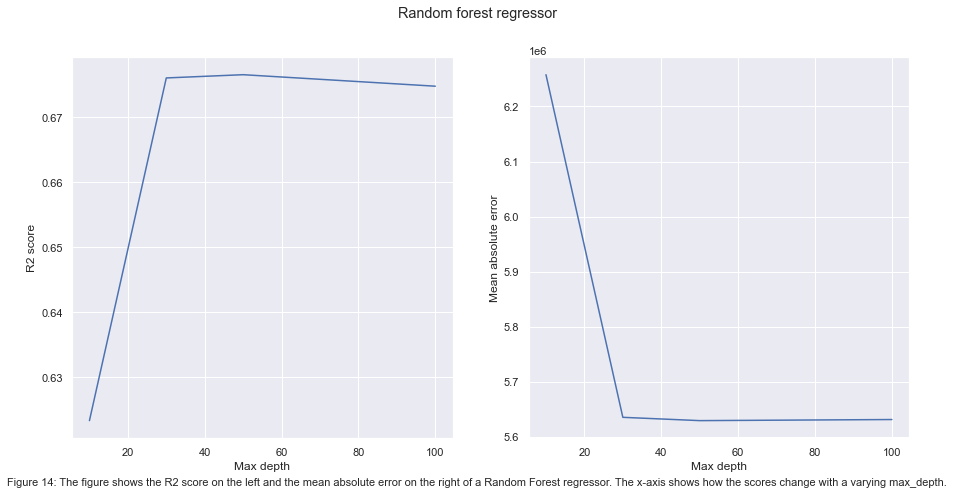

Best R2 score: 0.6765744802220282 with 50 max_depth 
Best MAE: 5629926.227886041 with 50 max_depth 


In [61]:
best_r2, best_mae = random_forest_generator(
    [None, 10, 30, 50, 100],
    X_pca, 
    y_pca, 
    'Figure {}: The figure shows the R2 score on the left and the mean absolute error on the right of a Random Forest regressor. The x-axis shows how the scores change with a varying max_depth.'.format(fig_nr), 
    "Random forest regressor")
fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

Neighbors trained: 40


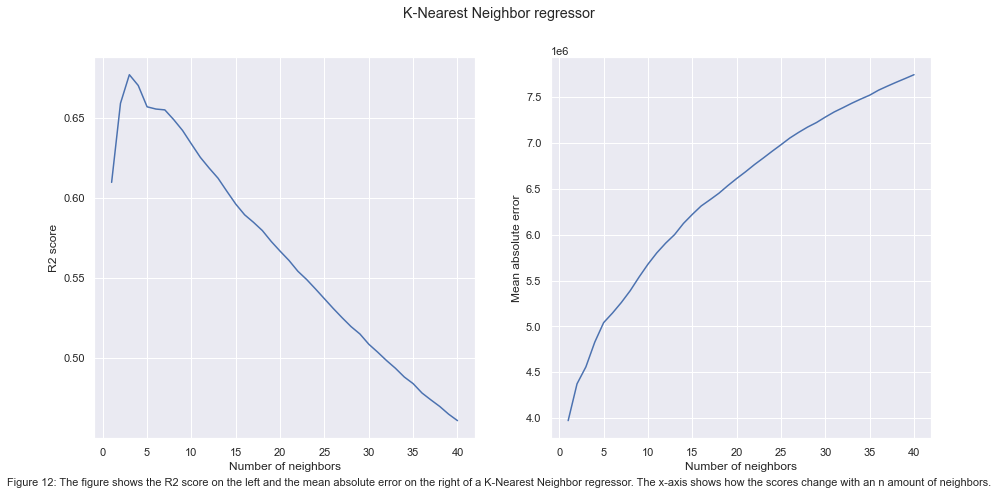

Best R2 score: 0.6768638972680027 with 3 max_depth 
Best MAE: 3973215.4259202196 with 1 max_depth 


In [62]:
best_r2, best_mae = knn_generator(
    range(1,41),
    X_pca, 
    y_pca, 
    'Figure {}: The figure shows the R2 score on the left and the mean absolute error on the right of a K-Nearest Neighbor regressor. The x-axis shows how the scores change with an n amount of neighbors.'.format(fig_nr), 
    "K-Nearest Neighbor regressor")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

### Optimizing best model and metric using GridSearch

The K-Nearest Neighbor regressor on the absolute data proves to be the best performing model when it comes to mean absolute error, which will be the measure main measure of the competition. To further optimize this model, we will apply GridSearch on the same data. We will use the standard values for the main hyperparameters. For the number of neighbors we will check the numbers corresponding to the Fibonacci sequence.

In [52]:
# Initiate GridSearch parameters for the K-Nearest Neighbors regressor (which is the model with the lowest MAE)
grid_params = { 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'],
    'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34]
}

clf = GridSearchCV(KNeighborsRegressor(), grid_params, verbose=1, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
    
clf_results = clf.fit(X_abs, y_abs)

print(clf_results.best_estimator_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   13.4s finished


KNeighborsRegressor(metric='manhattan', n_neighbors=2, weights='distance')


In [53]:
# Let's test if the prediction has improved
kf = KFold(n_splits=10, random_state=42, shuffle=True)
    
model = clf_results.best_estimator_
   
r2_sc = np.array([])
mae_score = np.array([])
    
for train_index, test_index in kf.split(X_abs):        
    X_train, X_test = X_abs[train_index], X_abs[test_index]
    y_train, y_test = y_abs[train_index], y_abs[test_index]

    model = model.fit(X_train, y_train)

    pred = model.predict(X_test)

    r2_sc = np.append(r2_sc, r2_score(y_test, pred))
    mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))
    
print(r2_sc.mean())
print(mae_score.mean())

0.7071072735296211
3952597.1664786004


### Train on all the data
We have seen that KNN performs best on absolute data (including PCA does not make a difference). The next step is to use the best estimator variable from the Grid Search object to instantly test the best parameters for the KNN model.

In [54]:
train_all = pd.read_csv("data/intermediate/aggregated_abs_train.csv")
submission_files = pd.read_csv("data/intermediate/aggregated_abs_test.csv")
    
train_all = clean_df(train_all)
submission_files = clean_df(submission_files)

train_all.head()

sensor_1_kurtosis  sensor_10_kurtosis  sensor_2_kurtosis  \
segment_id                                                             
757144677            3.526094            8.940736          25.919718   
684012682            9.732040           11.343385          16.772796   
150692731            3.123129            7.152505          19.425024   
658099461            5.093539           18.528364          33.755994   
1726437005           4.333028            6.338226          14.724671   

            sensor_3_kurtosis  sensor_4_kurtosis  sensor_5_kurtosis  \
segment_id                                                            
757144677            2.520061           1.397474          49.799338   
684012682            3.739625           5.267583          58.701665   
150692731            4.543157           4.667316          42.722814   
658099461            3.506672           8.530541          30.182713   
1726437005           4.428419           5.891275          25.811665   

            sensor_6_kurtosis  sensor_7_kurtosis  sensor_8_kurtosis  \
segment_id                                                            
757144677           10.652386           3.148650           1.813752   
684012682            2.468255           1.030223           3.270216   
150692731            1.294553           1.663043           1.004756   
658099461           14.197751          20.784153          22.545142   
1726437005           2.135182           2.435776           0.476493   

            sensor_9_kurtosis  ...  sensor_10_sum  sensor_2_sum  sensor_3_sum  \
segment_id                     ...                                              
757144677            2.630062  ...      1405267.0     3345468.0      774729.0   
684012682            4.748106  ...      1488792.0     2111899.0      702688.0   
150692731            8.054718  ...      1372630.0     1994281.0      646025.0   
658099461            9.875920  ...      1557164.0     2947197.0      687986.0   
1726437005           4.817078  ...      1391401.0     2058951.0      687401.0   

            sensor_4_sum  sensor_5_sum  sensor_6_sum  sensor_7_sum  \
segment_id                                                           
757144677      1747194.0      637002.0     3871824.0     3138344.0   
684012682       805219.0      451180.0     1713362.0     1020445.0   
150692731       787942.0      406657.0     1711440.0     1041929.0   
658099461       860351.0     1178577.0     3512114.0     1202095.0   
1726437005      757626.0      420941.0     2069531.0     1056078.0   

            sensor_8_sum  sensor_9_sum  time_to_eruption  
segment_id                                                
757144677      2364276.0     1179857.0          33318990  
684012682      1292443.0      820112.0          19770960  
150692731      1146433.0      792735.0          21438625  
658099461      1991485.0      881290.0          31870009  
1726437005     1192538.0      774688.0          21379271  

[5 rows x 121 columns]

In [55]:
# Create a final X and Y variable, which will be used to construct the submission dataframe 
X_final = train_all.drop(['time_to_eruption'], axis=1).values
y_final = train_all['time_to_eruption'].values

X_submission = submission_files.drop(['time_to_eruption'], axis=1).values
segment_ids = submission_files.index

In [56]:
# For the final model, use the clf best_estimator variable
model = clf_results.best_estimator_
model.fit(X_final, y_final)

# Generate predictions
preds = model.predict(X_submission)

#### Generating submission set

In [57]:
# Create a dictionary for our values
values = {'segment_id':segment_ids,'time_to_eruption':preds}

# Create a new dataframe to house the 'test' segment ids and time to eruptions
df_submission = pd.DataFrame(values)
df_submission.head()

segment_id  time_to_eruption
0  1711679486      2.139991e+07
1   445697187      2.108030e+07
2   247784329      2.189449e+07
3   620920171      2.187721e+07
4  1138064736      3.159671e+07

In [58]:
df_submission.shape

(4520, 2)

In [59]:
# To be sure, check if the shape of the data set corresponds with the number of rows required by the Kaggle submission page
if df_submission.shape[0] == 4520:
    df_submission.to_csv('submission.csv', index=False)  